## Step 1: Access project directory

### 1a. For Google Colaboratory

In [25]:
# Mounting the Google Drive to access and store files
from google.colab import drive
import os

drive.mount('/content/gdrive')
project_dir = "/content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02"
os.makedirs(project_dir, exist_ok=True)
%cd $project_dir

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02


### 1b. For Amazon SageMaker

In [ ]:
import os

project_dir = "/root/Course/Reinforcement_Learning/Assg_02"
os.makedirs(project_dir, exist_ok=True)
%cd $project_dir

## Step 2: Install packages

In [2]:
# Update the package lists for upgrades and new package installations

# Update the package lists and then install required packages for video visualization
!apt-get update && apt-get install swig cmake ffmpeg freeglut3-dev xvfb
# Install box2d-py, a 2D physics engine
!pip install box2d-py
# Install a specific version of stable-baselines3 with extra dependencies
!pip install "stable-baselines3[extra]>=2.0.0a4"


# Import necessary libraries and modules

from typing import Type, Optional, List, Union
import torch
import gymnasium as gym
import stable_baselines3
from pathlib import Path
from IPython import display as ipythondisplay
from stable_baselines3 import DQN, PPO, A2C, SAC, TD3
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv, VecFrameStack
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import base64
import shutil

# Print the versions of gymnasium and stable_baselines3 for debugging purposes
print(f"{gym.__version__=}")
print(f"{stable_baselines3.__version__=}")

# Set up a fake display for rendering videos
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:4 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:5 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:6 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:8 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [929 kB]
Hit:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [2,479 kB]
Get:13 http://archive.ubuntu.com/

## Step 3: Define model

In [26]:
class SaveOnIntervalCallback(BaseCallback):
    def __init__(self, total_step: int, current_step: int, save_interval: int, models_dir: str, verbose: int = 1):
        super().__init__(verbose)
        self._save_interval_ = save_interval
        self._total_step_ = total_step
        self._next_interval_ = current_step - (current_step % save_interval) + save_interval
        self._models_dir_ = models_dir

    def _on_step(self) -> bool:
        return True

    def _on_rollout_end(self):
        if self.num_timesteps >= self._next_interval_:
            save_file = RLUtils.identifier_to_filename(self._models_dir_, self._next_interval_)
            self.model.save(save_file)
            self._next_interval_ += self._save_interval_
            if self.verbose > 0:
                print(f'Saving model to {save_file}')

    def _on_training_end(self):
        """This event is triggered before exiting the `learn()` method."""
        save_file = RLUtils.identifier_to_filename(self._models_dir_, self._total_step_)
        self.model.save(save_file)
        if self.verbose > 0:
            print(f'Saving model to {save_file}')


class RLUtils:
    @staticmethod
    def setup_atari_env(env_name: str, n_envs: int = 1, seed: int = 0, n_stack: int = 4) -> VecFrameStack:
        """Set up an Atari environment with frame stacking."""
        env = make_atari_env(env_name, n_envs=n_envs, seed=seed)
        env = VecFrameStack(env, n_stack=n_stack)  # Stack consecutive frames together
        return env

    @staticmethod
    def get_model_class(algo: str) -> Union[Type[DQN], Type[A2C], Type[TD3], Type[SAC], Type[PPO]]:
        """Return the model class based on the given algorithm name."""
        model_classes = {
            "DQN": DQN, "A2C": A2C, "TD3": TD3, "SAC": SAC, "PPO": PPO
        }
        if algo in model_classes:
            return model_classes[algo]
        else:
            raise ValueError(f"Unknown algorithm: {algo}")

    @staticmethod
    def setup_model_with_last_saved(models_dir: str, algo: str, env, hyperparams: dict) -> Union[DQN, A2C, TD3, SAC, PPO]:
        """Setup model and load the latest saved model if it exists."""
        identifiers = RLUtils.get_model_identifiers(models_dir)
        last_model_path = RLUtils.identifier_to_filename(models_dir, identifiers[-1]) if identifiers else None

        model = RLUtils.get_model_class(algo)(env=env, verbose=1, **hyperparams)  # Initialize model

        if last_model_path:
            model.load(last_model_path)
            model.set_env(env)
            model.num_timesteps = identifiers[-1]
            print(f"Loaded model from {last_model_path} with {model.num_timesteps} step.")
        else:
            print(f"{models_dir} is empty or contains no model files.")
        return model

    @staticmethod
    def record_video(video_dir: str, env_name: str, env_type: str, model, video_length: int = 500, prefix: str = "") -> None:
        """Record a video of the agent playing."""
        if env_type == "Atari":
            eval_env = RLUtils.setup_atari_env(env_name, n_envs=1, seed=0, n_stack=4)
        elif env_type == "ClassicControl":
            eval_env = DummyVecEnv([lambda: gym.make(env_name, render_mode='rgb_array')])
        else:
            raise ValueError(f"Unsupported environment type: {env_type}")
        eval_env = VecVideoRecorder(
            eval_env, video_folder=video_dir,
            record_video_trigger=lambda step: step == 0,
            video_length=video_length, name_prefix=prefix,
        )
        obs = eval_env.reset()
        for _ in range(video_length):
            action, _ = model.predict(obs)
            obs, _, _, _ = eval_env.step(action)
        eval_env.close()

    @staticmethod
    def show_videos(video_path: str, prefix: str = "") -> None:
        """Display recorded videos."""
        html = []
        # Reading and encoding videos to display
        for mp4 in Path(video_path).glob(f"{prefix}*.mp4"):
            print(mp4)
            video_b64 = base64.b64encode(mp4.read_bytes())
            html.append(f'''<video alt="{mp4}" autoplay loop controls style="height: 400px;">
                                <source src="data:video/mp4;base64,{video_b64.decode('ascii')}" type="video/mp4" />
                            </video>''')
        ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))  # Displaying the videos

    @staticmethod
    def view(models_dir: str, video_dir: str, env_name: str, env_type: str, algo: str, video_length: int) -> None:
        """View videos of the models at different training stages."""
        stages = ["final", "three-quarters", "half", "quarter"]
        identifiers = RLUtils.get_model_identifiers(models_dir)
        final_value = identifiers[-1]
        key_identifiers = [final_value,
                           RLUtils.find_closest(final_value * 3 // 4, identifiers),
                           RLUtils.find_closest(final_value // 2, identifiers),
                           RLUtils.find_closest(final_value // 4, identifiers)]

        # Record videos at the beginning, middle, and end of training
        for stage, identifier in zip(stages, key_identifiers):
            model = RLUtils.get_model_class(algo).load(RLUtils.identifier_to_filename(models_dir, identifier))
            RLUtils.record_video(video_dir, env_name, env_type, model, video_length, f'{env_name}-{algo}-{stage}-{identifier}')

        # Displaying the videos
        for stage in stages:
            RLUtils.show_videos(video_dir, prefix=f'{env_name}-{algo}-{stage}')

    @staticmethod
    def identifier_to_filename(models_dir: str, identifier: int) -> str:
        """Convert identifier to model filename."""
        return os.path.join(models_dir, f"model_{identifier}.zip")

    @staticmethod
    def filename_to_identifier(model_file: str) -> int:
        """Extract identifier from model filename."""
        return int(model_file.split('_')[-1].split('.')[0])

    @staticmethod
    def get_model_identifiers(models_dir: str) -> List[int]:
        """Retrieve sorted model identifiers from model filenames."""
        model_files = [f for f in os.listdir(models_dir) if f.startswith('model_') and f.endswith('.zip')]
        return sorted([RLUtils.filename_to_identifier(f) for f in model_files])

    @staticmethod
    def find_closest(value: int, identifiers: List[int]) -> int:
        """Find the identifier closest to a given value."""
        return min(identifiers, key=lambda x: abs(x - value))

    @staticmethod
    def cleanup_models(models_dir: str, total_step: int, save_interval: int) -> None:
        """Remove model files that don't match save interval or exceed total step."""
        for identifier in RLUtils.get_model_identifiers(models_dir):
            if identifier % save_interval != 0 or identifier > total_step:
                model_file = RLUtils.identifier_to_filename(models_dir, identifier)
                os.remove(model_file)
                print(f"Removed model file: {model_file}")

    @staticmethod
    def plot_results(log_folder: str, title: str = "Learning Curve") -> None:
        x, y = ts2xy(load_results(log_folder), "timesteps")  # Loading the results
        y = np.convolve(y, np.ones((50,)) / 50, mode='valid')  # Smoothing the curve using a moving average of 50 episodes
        x = x[len(x) - len(y):]  # Adjusting the x-axis values
        plt.figure(figsize=(10, 5))  # Setting figure size
        plt.plot(x, y)  # Plotting the learning curve
        plt.xlabel("Number of Timesteps")  # Labeling x-axis
        plt.ylabel("Rewards")  # Labeling y-axis
        plt.title(title + " Smoothed")  # Adding title to the plot
        plt.show()  # Displaying the plot

class BaseAgent:
    def __init__(self, algo: str, run_id: str, project_dir: str, env_name: str, hyperparams: Optional[dict] = None):
        """Initializes the base agent with common attributes."""
        self.algo = algo
        self.run_id = run_id
        self.project_dir = project_dir
        self.env_name = env_name
        self.hyperparams = hyperparams if hyperparams else {}
        self.env, self.model = None, None
        self._initialize_directories()

    def _initialize_directories(self) -> None:
        """Sets up the directories for logging, models, and videos."""
        # Directories differentiated by run_id
        self.log_dir = os.path.join(self.project_dir, self.run_id, "gym")
        self.models_dir = os.path.join(self.project_dir, self.run_id, "models")
        self.video_dir = os.path.join(self.project_dir, self.run_id, "videos")
        # Create directories if they don't exist
        os.makedirs(self.log_dir, exist_ok=True)
        os.makedirs(self.models_dir, exist_ok=True)
        os.makedirs(self.video_dir, exist_ok=True)

    def train_agent(self, total_step: int, save_interval: Optional[int] = None) -> None:
        """Trains the agent for a specified number of step."""
        if not save_interval:
            save_interval = total_step // 8
        RLUtils.cleanup_models(self.models_dir, total_step, save_interval)
        self.model = RLUtils.setup_model_with_last_saved(self.models_dir, self.algo, self.env, self.hyperparams)
        current_step = getattr(self.model, 'num_timesteps', 0)
        step_to_train = total_step - current_step
        save_callback = SaveOnIntervalCallback(total_step, current_step, save_interval, self.models_dir)
        self.model.learn(total_timesteps=step_to_train, callback=save_callback, reset_num_timesteps=False)
        self.model.save(os.path.join(self.models_dir, f"model_{total_step}.zip"))

    def evaluate_agent(self) -> None:
        """Evaluates the agent's performance."""
        # Clear the video directory
        shutil.rmtree(self.video_dir)
        # Evaluation may vary per agent type, so defer to subclass
        self._internal_evaluation()

    def run_agent(self, total_step: int, save_interval: Optional[int] = None) -> None:
        """Sets up the environment, trains, and evaluates the agent."""
        self._configure_environment()
        self.train_agent(total_step, save_interval)

    def _configure_environment(self) -> None:
        """Sets up the environment specific to the agent type."""
        raise NotImplementedError("Child classes must implement this method.")

    def _internal_evaluation(self) -> None:
        """Agent-specific evaluation after training."""
        raise NotImplementedError("Child classes must implement this method.")


class AtariAgent(BaseAgent):
    def _configure_environment(self) -> None:
        """Sets up the Atari environment with specific configurations."""
        self.env = RLUtils.setup_atari_env(self.env_name, n_envs=4, seed=0, n_stack=4)

    def _internal_evaluation(self) -> None:
        """Evaluates the Atari agent's performance."""
        RLUtils.view(self.models_dir, self.video_dir, self.env_name, "Atari", self.algo, 1000)


class ClassicControlAgent(BaseAgent):
    def _configure_environment(self) -> None:
        """Sets up the Classic Control environment."""
        self.env = DummyVecEnv([lambda: Monitor(gym.make(self.env_name), self.log_dir)])

    def _internal_evaluation(self) -> None:
        """Evaluates the Classic Control agent and plots results."""
        RLUtils.view(self.models_dir, self.video_dir, self.env_name, "ClassicControl", self.algo, 500)
        RLUtils.plot_results(self.log_dir)

## Step 4: Train model

### 4a. Pendulum

#### Pendulum TD3 Input Set 1: Basic configuration

In [27]:
class TD3CustomMLP_v1(BaseFeaturesExtractor):
    def __init__(self, observation_space: gym.spaces.Box, features_dim: int = 128):
        super(TD3CustomMLP_v1, self).__init__(observation_space, features_dim)
        # Using a simple 2-layer architecture with 64 and 128 neurons respectively
        self.net = nn.Sequential(
            nn.Linear(observation_space.shape[0], 64),
            nn.ReLU(),
            nn.Linear(64, features_dim),
            nn.ReLU()
        )

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        return self.net(observations)

# Moderate learning rate and larger buffer size to facilitate stable learning over time
td3_v1_hyperparams = {
    'policy': 'MlpPolicy',
    'learning_rate': 1e-3,
    'batch_size': 128,
    'buffer_size': 100000,
    'train_freq': 1000,
    'gradient_steps': 1000,
    'learning_starts': 10000,
    'policy_kwargs': {'features_extractor_class': TD3CustomMLP_v1}
}
td3_v1_agent = ClassicControlAgent(algo="TD3", run_id="Pendulum_TD3_1", project_dir=project_dir, env_name="Pendulum-v1", hyperparams=td3_v1_hyperparams)

In [28]:
td3_v1_agent.run_agent(total_step=40 * 1000, save_interval=5 * 1000)  # Aiming for long training to get finer results

Using cuda device
/content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_1/models is empty or contains no model files.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -1.19e+03 |
| time/              |           |
|    episodes        | 4         |
|    fps             | 5127      |
|    time_elapsed    | 0         |
|    total_timesteps | 800       |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -1.15e+03 |
| time/              |           |
|    episodes        | 8         |
|    fps             | 5244      |
|    time_elapsed    | 0         |
|    total_timesteps | 1600      |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -1.15e+03 |
| time/              

Saving video to /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_1/videos/Pendulum-v1-TD3-final-40000-step-0-to-step-500.mp4
Moviepy - Building video /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_1/videos/Pendulum-v1-TD3-final-40000-step-0-to-step-500.mp4.
Moviepy - Writing video /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_1/videos/Pendulum-v1-TD3-final-40000-step-0-to-step-500.mp4



Moviepy - Done !
Moviepy - video ready /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_1/videos/Pendulum-v1-TD3-final-40000-step-0-to-step-500.mp4
Saving video to /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_1/videos/Pendulum-v1-TD3-three-quarters-30000-step-0-to-step-500.mp4
Moviepy - Building video /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_1/videos/Pendulum-v1-TD3-three-quarters-30000-step-0-to-step-500.mp4.
Moviepy - Writing video /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_1/videos/Pendulum-v1-TD3-three-quarters-30000-step-0-to-step-500.mp4



Moviepy - Done !
Moviepy - video ready /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_1/videos/Pendulum-v1-TD3-three-quarters-30000-step-0-to-step-500.mp4
Saving video to /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_1/videos/Pendulum-v1-TD3-half-20000-step-0-to-step-500.mp4
Moviepy - Building video /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_1/videos/Pendulum-v1-TD3-half-20000-step-0-to-step-500.mp4.
Moviepy - Writing video /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_1/videos/Pendulum-v1-TD3-half-20000-step-0-to-step-500.mp4



Moviepy - Done !
Moviepy - video ready /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_1/videos/Pendulum-v1-TD3-half-20000-step-0-to-step-500.mp4
Saving video to /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_1/videos/Pendulum-v1-TD3-quarter-10000-step-0-to-step-500.mp4
Moviepy - Building video /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_1/videos/Pendulum-v1-TD3-quarter-10000-step-0-to-step-500.mp4.
Moviepy - Writing video /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_1/videos/Pendulum-v1-TD3-quarter-10000-step-0-to-step-500.mp4



Moviepy - Done !
Moviepy - video ready /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_1/videos/Pendulum-v1-TD3-quarter-10000-step-0-to-step-500.mp4
/content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_1/videos/Pendulum-v1-TD3-final-40000-step-0-to-step-500.mp4


/content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_1/videos/Pendulum-v1-TD3-three-quarters-30000-step-0-to-step-500.mp4


/content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_1/videos/Pendulum-v1-TD3-half-20000-step-0-to-step-500.mp4


/content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_1/videos/Pendulum-v1-TD3-quarter-10000-step-0-to-step-500.mp4


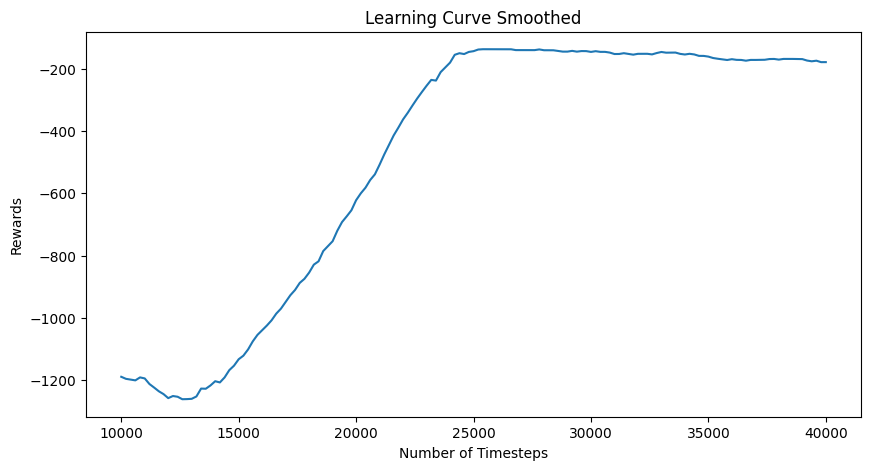

In [29]:
td3_v1_agent.evaluate_agent()

#### Pendulum TD3 Input Set 2: Increase complexity

In [30]:
class TD3CustomMLP_v2(BaseFeaturesExtractor):
    def __init__(self, observation_space: gym.spaces.Box, features_dim: int = 256):
        super(TD3CustomMLP_v2, self).__init__(observation_space, features_dim)
        # A slightly deeper architecture for more complex feature extraction
        self.net = nn.Sequential(
            nn.Linear(observation_space.shape[0], 128),
            nn.ReLU(),
            nn.Linear(128, features_dim),
            nn.ReLU()
        )

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        return self.net(observations)

# Slightly aggressive learning rate with a moderate buffer size for quicker convergence
td3_v2_hyperparams = {
    'policy': 'MlpPolicy',
    'learning_rate': 1e-3,
    'batch_size': 128,
    'buffer_size': 500000,
    'train_freq': 500,
    'gradient_steps': -1,
    'gamma': 0.98,
    'learning_starts': 10000,
    'policy_kwargs': {'features_extractor_class': TD3CustomMLP_v2}
}
td3_v2_agent = ClassicControlAgent(algo="TD3", run_id="Pendulum_TD3_2", project_dir=project_dir, env_name="Pendulum-v1", hyperparams=td3_v2_hyperparams)

In [31]:
td3_v2_agent.run_agent(total_step=40 * 1000, save_interval=5 * 1000)

Using cuda device
/content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_2/models is empty or contains no model files.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | -988     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 5261     |
|    time_elapsed    | 0        |
|    total_timesteps | 800      |
---------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -1.06e+03 |
| time/              |           |
|    episodes        | 8         |
|    fps             | 5019      |
|    time_elapsed    | 0         |
|    total_timesteps | 1600      |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -1.12e+03 |
| time/              |         

Saving video to /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_2/videos/Pendulum-v1-TD3-final-40000-step-0-to-step-500.mp4
Moviepy - Building video /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_2/videos/Pendulum-v1-TD3-final-40000-step-0-to-step-500.mp4.
Moviepy - Writing video /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_2/videos/Pendulum-v1-TD3-final-40000-step-0-to-step-500.mp4



Moviepy - Done !
Moviepy - video ready /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_2/videos/Pendulum-v1-TD3-final-40000-step-0-to-step-500.mp4
Saving video to /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_2/videos/Pendulum-v1-TD3-three-quarters-30000-step-0-to-step-500.mp4
Moviepy - Building video /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_2/videos/Pendulum-v1-TD3-three-quarters-30000-step-0-to-step-500.mp4.
Moviepy - Writing video /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_2/videos/Pendulum-v1-TD3-three-quarters-30000-step-0-to-step-500.mp4



Moviepy - Done !
Moviepy - video ready /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_2/videos/Pendulum-v1-TD3-three-quarters-30000-step-0-to-step-500.mp4
Saving video to /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_2/videos/Pendulum-v1-TD3-half-20000-step-0-to-step-500.mp4
Moviepy - Building video /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_2/videos/Pendulum-v1-TD3-half-20000-step-0-to-step-500.mp4.
Moviepy - Writing video /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_2/videos/Pendulum-v1-TD3-half-20000-step-0-to-step-500.mp4



Moviepy - Done !
Moviepy - video ready /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_2/videos/Pendulum-v1-TD3-half-20000-step-0-to-step-500.mp4
Saving video to /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_2/videos/Pendulum-v1-TD3-quarter-10000-step-0-to-step-500.mp4
Moviepy - Building video /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_2/videos/Pendulum-v1-TD3-quarter-10000-step-0-to-step-500.mp4.
Moviepy - Writing video /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_2/videos/Pendulum-v1-TD3-quarter-10000-step-0-to-step-500.mp4



Moviepy - Done !
Moviepy - video ready /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_2/videos/Pendulum-v1-TD3-quarter-10000-step-0-to-step-500.mp4
/content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_2/videos/Pendulum-v1-TD3-final-40000-step-0-to-step-500.mp4


/content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_2/videos/Pendulum-v1-TD3-three-quarters-30000-step-0-to-step-500.mp4


/content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_2/videos/Pendulum-v1-TD3-half-20000-step-0-to-step-500.mp4


/content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_2/videos/Pendulum-v1-TD3-quarter-10000-step-0-to-step-500.mp4


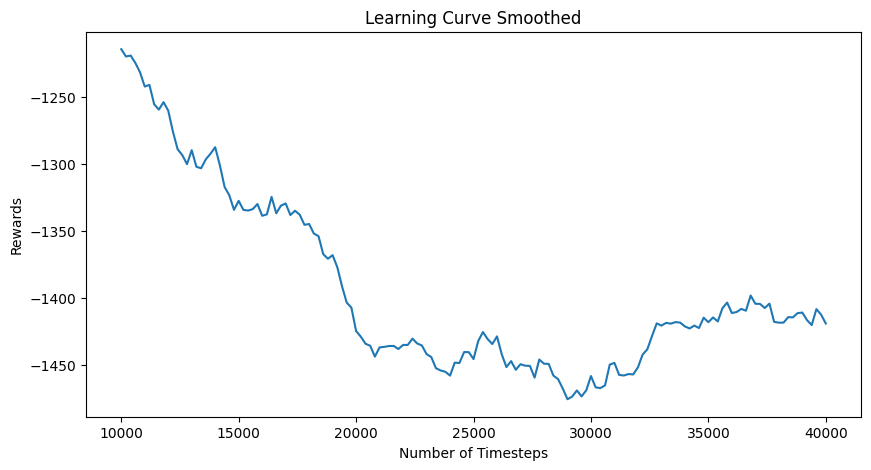

In [32]:
td3_v2_agent.evaluate_agent()

#### Pendulum TD3 Input Set 3: Higher learning rate

In [39]:
class TD3CustomMLP_v3(BaseFeaturesExtractor):
    def __init__(self, observation_space: gym.spaces.Box, features_dim: int = 64):
        super(TD3CustomMLP_v3, self).__init__(observation_space, features_dim)
        # A smaller architecture for faster training and lightweight feature extraction
        self.net = nn.Sequential(
            nn.Linear(observation_space.shape[0], 32),
            nn.ReLU(),
            nn.Linear(32, features_dim),
            nn.ReLU()
        )

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        return self.net(observations)

# Conservative learning rate and smaller buffer size aimed for quicker but stable training sessions
td3_v3_hyperparams = {
    'policy': 'MlpPolicy',
    'learning_rate': 5e-4,
    'batch_size': 50,
    'buffer_size': 250000,
    'train_freq': 250,
    'gradient_steps': 500,
    'policy_kwargs': {'features_extractor_class': TD3CustomMLP_v3}
}
td3_v3_agent = ClassicControlAgent(algo="TD3", run_id="Pendulum_TD3_3", project_dir=project_dir, env_name="Pendulum-v1", hyperparams=td3_v3_hyperparams)

In [40]:
td3_v3_agent.run_agent(total_step=40 * 1000, save_interval=5 * 1000)  # Targeting medium duration of training for this setup

Using cuda device
/content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_3/models is empty or contains no model files.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -1.46e+03 |
| time/              |           |
|    episodes        | 4         |
|    fps             | 71        |
|    time_elapsed    | 11        |
|    total_timesteps | 800       |
| train/             |           |
|    actor_loss      | 21.4      |
|    critic_loss     | 0.119     |
|    learning_rate   | 0.0005    |
|    n_updates       | 1500      |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -1.41e+03 |
| time/              |           |
|    episodes        | 8         |
|    fps             | 71        |
|    time_elapsed    | 22        |
|    total_timesteps | 1600      |
| train/             

Saving video to /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_3/videos/Pendulum-v1-TD3-final-40000-step-0-to-step-500.mp4
Moviepy - Building video /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_3/videos/Pendulum-v1-TD3-final-40000-step-0-to-step-500.mp4.
Moviepy - Writing video /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_3/videos/Pendulum-v1-TD3-final-40000-step-0-to-step-500.mp4



Moviepy - Done !
Moviepy - video ready /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_3/videos/Pendulum-v1-TD3-final-40000-step-0-to-step-500.mp4
Saving video to /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_3/videos/Pendulum-v1-TD3-three-quarters-30000-step-0-to-step-500.mp4
Moviepy - Building video /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_3/videos/Pendulum-v1-TD3-three-quarters-30000-step-0-to-step-500.mp4.
Moviepy - Writing video /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_3/videos/Pendulum-v1-TD3-three-quarters-30000-step-0-to-step-500.mp4



Moviepy - Done !
Moviepy - video ready /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_3/videos/Pendulum-v1-TD3-three-quarters-30000-step-0-to-step-500.mp4
Saving video to /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_3/videos/Pendulum-v1-TD3-half-20000-step-0-to-step-500.mp4
Moviepy - Building video /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_3/videos/Pendulum-v1-TD3-half-20000-step-0-to-step-500.mp4.
Moviepy - Writing video /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_3/videos/Pendulum-v1-TD3-half-20000-step-0-to-step-500.mp4



Moviepy - Done !
Moviepy - video ready /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_3/videos/Pendulum-v1-TD3-half-20000-step-0-to-step-500.mp4
Saving video to /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_3/videos/Pendulum-v1-TD3-quarter-10000-step-0-to-step-500.mp4
Moviepy - Building video /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_3/videos/Pendulum-v1-TD3-quarter-10000-step-0-to-step-500.mp4.
Moviepy - Writing video /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_3/videos/Pendulum-v1-TD3-quarter-10000-step-0-to-step-500.mp4



Moviepy - Done !
Moviepy - video ready /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_3/videos/Pendulum-v1-TD3-quarter-10000-step-0-to-step-500.mp4
/content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_3/videos/Pendulum-v1-TD3-final-40000-step-0-to-step-500.mp4


/content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_3/videos/Pendulum-v1-TD3-three-quarters-30000-step-0-to-step-500.mp4


/content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_3/videos/Pendulum-v1-TD3-half-20000-step-0-to-step-500.mp4


/content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/Pendulum_TD3_3/videos/Pendulum-v1-TD3-quarter-10000-step-0-to-step-500.mp4


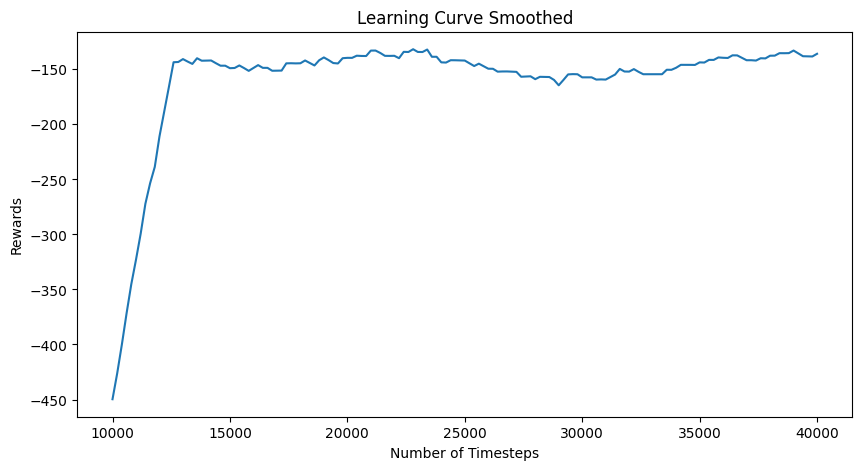

In [41]:
td3_v3_agent.evaluate_agent()

### 4b. CartPole

#### CartPole DQN Input Set 1: Basic Configuration

In [33]:
class DQNCustomMLP_v1(BaseFeaturesExtractor):
    def __init__(self, observation_space: gym.spaces.Box, features_dim: int = 128):
        super(DQNCustomMLP_v1, self).__init__(observation_space, features_dim)

        self.net = nn.Sequential(
            nn.Linear(observation_space.shape[0], 64),
            nn.ReLU(),
            nn.Linear(64, features_dim),
            nn.ReLU()
        )

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        return self.net(observations)

dqn_v1_hyperparams = {
    'policy': 'MlpPolicy',
    'learning_rate': 0.001,
    'buffer_size': 50000,
    'learning_starts': 1000,
    'gradient_steps': 1,
    'exploration_fraction': 0.1,
    'exploration_final_eps': 0.05,
    'train_freq': 1,
    'batch_size': 32,
    'policy_kwargs': {'features_extractor_class': DQNCustomMLP_v1}
}
dqn_v1_agent = ClassicControlAgent(algo="DQN", run_id="CartPole_DQN_1", project_dir=project_dir, env_name="CartPole-v1", hyperparams=dqn_v1_hyperparams)

In [34]:
dqn_v1_agent.run_agent(total_step=200 * 1000, save_interval=25 * 1000)  # 200,000 timesteps

Streaming output truncated to the last 5000 lines.
|    ep_len_mean      | 134      |
|    ep_rew_mean      | 134      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1664     |
|    fps              | 235      |
|    time_elapsed     | 306      |
|    total_timesteps  | 72149    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00576  |
|    n_updates        | 71148    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 133      |
|    ep_rew_mean      | 133      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1668     |
|    fps              | 235      |
|    time_elapsed     | 308      |
|    total_timesteps  | 72583    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00765  |
|    n_updates        | 71582    |
----

Saving video to /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/CartPole_DQN_1/videos/CartPole-v1-DQN-final-200000-step-0-to-step-500.mp4
Moviepy - Building video /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/CartPole_DQN_1/videos/CartPole-v1-DQN-final-200000-step-0-to-step-500.mp4.
Moviepy - Writing video /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/CartPole_DQN_1/videos/CartPole-v1-DQN-final-200000-step-0-to-step-500.mp4



Moviepy - Done !
Moviepy - video ready /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/CartPole_DQN_1/videos/CartPole-v1-DQN-final-200000-step-0-to-step-500.mp4
Saving video to /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/CartPole_DQN_1/videos/CartPole-v1-DQN-three-quarters-150000-step-0-to-step-500.mp4
Moviepy - Building video /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/CartPole_DQN_1/videos/CartPole-v1-DQN-three-quarters-150000-step-0-to-step-500.mp4.
Moviepy - Writing video /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/CartPole_DQN_1/videos/CartPole-v1-DQN-three-quarters-150000-step-0-to-step-500.mp4



Moviepy - Done !
Moviepy - video ready /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/CartPole_DQN_1/videos/CartPole-v1-DQN-three-quarters-150000-step-0-to-step-500.mp4
Saving video to /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/CartPole_DQN_1/videos/CartPole-v1-DQN-half-100000-step-0-to-step-500.mp4
Moviepy - Building video /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/CartPole_DQN_1/videos/CartPole-v1-DQN-half-100000-step-0-to-step-500.mp4.
Moviepy - Writing video /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/CartPole_DQN_1/videos/CartPole-v1-DQN-half-100000-step-0-to-step-500.mp4



Moviepy - Done !
Moviepy - video ready /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/CartPole_DQN_1/videos/CartPole-v1-DQN-half-100000-step-0-to-step-500.mp4
Saving video to /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/CartPole_DQN_1/videos/CartPole-v1-DQN-quarter-50000-step-0-to-step-500.mp4
Moviepy - Building video /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/CartPole_DQN_1/videos/CartPole-v1-DQN-quarter-50000-step-0-to-step-500.mp4.
Moviepy - Writing video /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/CartPole_DQN_1/videos/CartPole-v1-DQN-quarter-50000-step-0-to-step-500.mp4



Moviepy - Done !
Moviepy - video ready /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/CartPole_DQN_1/videos/CartPole-v1-DQN-quarter-50000-step-0-to-step-500.mp4
/content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/CartPole_DQN_1/videos/CartPole-v1-DQN-final-200000-step-0-to-step-500.mp4


/content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/CartPole_DQN_1/videos/CartPole-v1-DQN-three-quarters-150000-step-0-to-step-500.mp4


/content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/CartPole_DQN_1/videos/CartPole-v1-DQN-half-100000-step-0-to-step-500.mp4


/content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/CartPole_DQN_1/videos/CartPole-v1-DQN-quarter-50000-step-0-to-step-500.mp4


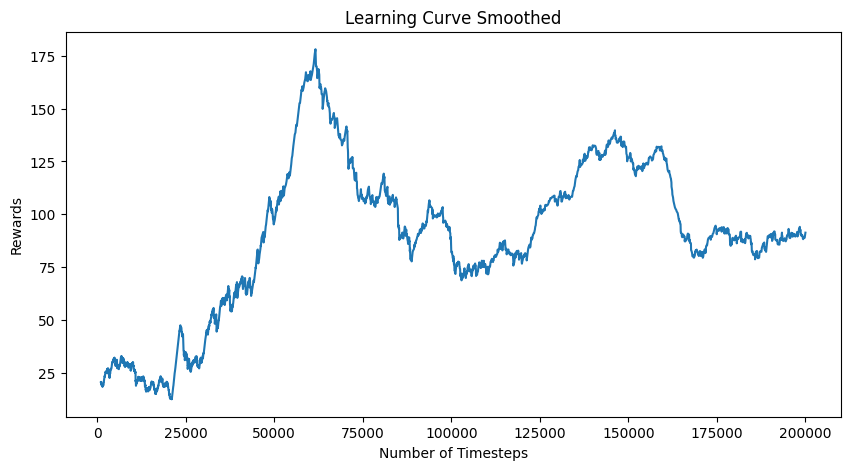

In [35]:
dqn_v1_agent.evaluate_agent()

#### CartPole DQN Input Set 2: Increase Complexity

In [36]:
# DQNCustomMLP_v2:
# Increasing the depth and width of the network can allow it to capture more complex representations.
class DQNCustomMLP_v2(BaseFeaturesExtractor):
    def __init__(self, observation_space: gym.spaces.Box, features_dim: int = 256):
        super(DQNCustomMLP_v2, self).__init__(observation_space, features_dim)

        self.net = nn.Sequential(
            nn.Linear(observation_space.shape[0], 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, features_dim),
            nn.ReLU()
        )

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        return self.net(observations)

# Hyperparameters for Optimized Configuration:
# - Increase buffer size for more experience replay. This gives the agent a broader range of experiences to learn from.
# - Modify the exploration fraction for longer exploration, which might be beneficial for certain complex environments.
dqn_v2_hyperparams = {
    'policy': 'MlpPolicy',
    'learning_rate': 0.001,
    'buffer_size': 100000,        # increased buffer size to store more experiences
    'learning_starts': 1000,
    'gradient_steps': 1,
    'exploration_fraction': 0.2,
    'exploration_final_eps': 0.02,
    'train_freq': 1,
    'batch_size': 64,           # larger batch size can stabilize learning in deeper networks
    'policy_kwargs': {'features_extractor_class': DQNCustomMLP_v2}
}
dqn_v2_agent = ClassicControlAgent(algo="DQN", run_id="CartPole_DQN_2", project_dir=project_dir, env_name="CartPole-v1", hyperparams=dqn_v2_hyperparams)

In [37]:
dqn_v2_agent.run_agent(total_step=400 * 1000, save_interval=25 * 1000)  # 400,000 timesteps

Streaming output truncated to the last 5000 lines.
|    ep_rew_mean      | 98.5     |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 3552     |
|    fps              | 219      |
|    time_elapsed     | 1064     |
|    total_timesteps  | 233256   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0589   |
|    n_updates        | 232255   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 101      |
|    ep_rew_mean      | 101      |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 3556     |
|    fps              | 218      |
|    time_elapsed     | 1067     |
|    total_timesteps  | 233772   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0175   |
|    n_updates        | 232771   |
----------------------------------
----

Saving video to /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/CartPole_DQN_2/videos/CartPole-v1-DQN-final-400000-step-0-to-step-500.mp4
Moviepy - Building video /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/CartPole_DQN_2/videos/CartPole-v1-DQN-final-400000-step-0-to-step-500.mp4.
Moviepy - Writing video /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/CartPole_DQN_2/videos/CartPole-v1-DQN-final-400000-step-0-to-step-500.mp4



Moviepy - Done !
Moviepy - video ready /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/CartPole_DQN_2/videos/CartPole-v1-DQN-final-400000-step-0-to-step-500.mp4
Saving video to /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/CartPole_DQN_2/videos/CartPole-v1-DQN-three-quarters-300000-step-0-to-step-500.mp4
Moviepy - Building video /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/CartPole_DQN_2/videos/CartPole-v1-DQN-three-quarters-300000-step-0-to-step-500.mp4.
Moviepy - Writing video /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/CartPole_DQN_2/videos/CartPole-v1-DQN-three-quarters-300000-step-0-to-step-500.mp4



Moviepy - Done !
Moviepy - video ready /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/CartPole_DQN_2/videos/CartPole-v1-DQN-three-quarters-300000-step-0-to-step-500.mp4
Saving video to /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/CartPole_DQN_2/videos/CartPole-v1-DQN-half-200000-step-0-to-step-500.mp4
Moviepy - Building video /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/CartPole_DQN_2/videos/CartPole-v1-DQN-half-200000-step-0-to-step-500.mp4.
Moviepy - Writing video /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/CartPole_DQN_2/videos/CartPole-v1-DQN-half-200000-step-0-to-step-500.mp4



Moviepy - Done !
Moviepy - video ready /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/CartPole_DQN_2/videos/CartPole-v1-DQN-half-200000-step-0-to-step-500.mp4
Saving video to /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/CartPole_DQN_2/videos/CartPole-v1-DQN-quarter-100000-step-0-to-step-500.mp4
Moviepy - Building video /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/CartPole_DQN_2/videos/CartPole-v1-DQN-quarter-100000-step-0-to-step-500.mp4.
Moviepy - Writing video /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/CartPole_DQN_2/videos/CartPole-v1-DQN-quarter-100000-step-0-to-step-500.mp4



Moviepy - Done !
Moviepy - video ready /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/CartPole_DQN_2/videos/CartPole-v1-DQN-quarter-100000-step-0-to-step-500.mp4
/content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/CartPole_DQN_2/videos/CartPole-v1-DQN-final-400000-step-0-to-step-500.mp4


/content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/CartPole_DQN_2/videos/CartPole-v1-DQN-three-quarters-300000-step-0-to-step-500.mp4


/content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/CartPole_DQN_2/videos/CartPole-v1-DQN-half-200000-step-0-to-step-500.mp4


/content/gdrive/MyDrive/Course/Reinforcement_Learning/Assg_02/CartPole_DQN_2/videos/CartPole-v1-DQN-quarter-100000-step-0-to-step-500.mp4


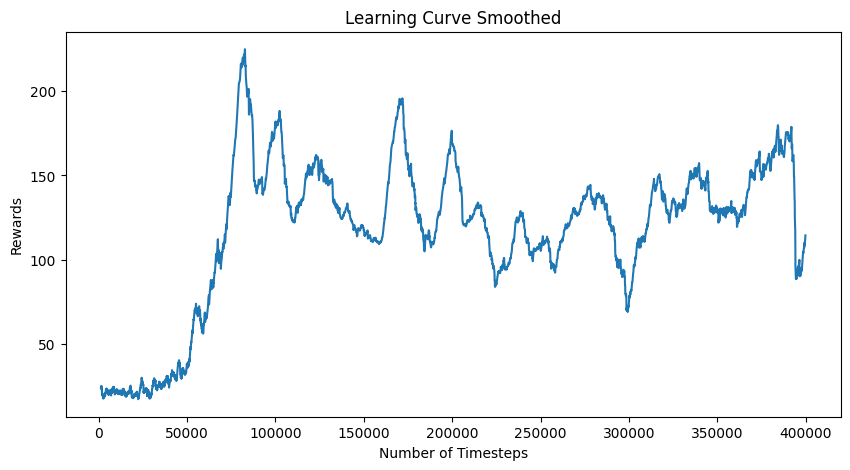

In [38]:
dqn_v2_agent.evaluate_agent()

#### CartPole PPO Input Set 1: Basic configuration

In [ ]:
# The simplest form of feature extraction using a basic 2-layer MLP.
# This architecture aims to provide a straightforward baseline for the CartPole problem.
class PPOCustomMLP_v1(BaseFeaturesExtractor):
    def __init__(self, observation_space: gym.spaces.Box, features_dim: int = 64):
        super(PPOCustomMLP_v1, self).__init__(observation_space, features_dim)
        self.net = nn.Sequential(
            nn.Linear(observation_space.shape[0], 32),  # Connect input to an intermediate layer
            nn.ReLU(),  # Non-linearity added
            nn.Linear(32, features_dim),  # Connect intermediate layer to the output layer
            nn.ReLU()
        )

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        return self.net(observations)

# Hyperparameters for the Basic MLP
# Chosen to start with a standard learning rate and batch size.
ppo_v1_hyperparams = {
    'policy': 'MlpPolicy',
    'learning_rate': 2.5e-4,
    'n_steps': 2048,
    'batch_size': 64,
    'n_epochs': 4,
    'clip_range': 0.2,
    'policy_kwargs': {'features_extractor_class': PPOCustomMLP_v1}
}
ppo_v1_agent = ClassicControlAgent(algo="PPO", run_id="CartPole_PPO_1", project_dir=project_dir, env_name="CartPole-v1", hyperparams=ppo_v1_hyperparams)

In [ ]:
ppo_v1_agent.run_agent(total_step=100 * 1000, save_interval=25 * 1000)  # 100,000 timesteps

In [ ]:
ppo_v1_agent.evaluate_agent()

#### CartPole PPO Input Set 2: Deeper MLP Architecture

In [ ]:
# A 3-layer MLP for a more nuanced representation.
# The idea is to capture more intricate details from the CartPole observations.
class PPOCustomMLP_v2(BaseFeaturesExtractor):
    def __init__(self, observation_space: gym.spaces.Box, features_dim: int = 64):
        super(PPOCustomMLP_v2, self).__init__(observation_space, features_dim)
        self.net = nn.Sequential(
            nn.Linear(observation_space.shape[0], 32),
            nn.ReLU(),
            nn.Linear(32, 32),  # Additional intermediate layer for deeper feature extraction
            nn.ReLU(),
            nn.Linear(32, features_dim),
            nn.ReLU()
        )

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        return self.net(observations)

# Hyperparameters optimized for the deeper MLP.
# Increased number of epochs to ensure convergence.
ppo_v2_hyperparams = {
    'policy': 'MlpPolicy',
    'learning_rate': 3e-4,
    'n_steps': 1024,
    'batch_size': 32,  # Reduced batch size to cater for a deeper network and ensure robust gradient updates.
    'n_epochs': 6,
    'clip_range': 0.15,  # Slightly reduced clipping range.
    'policy_kwargs': {'features_extractor_class': PPOCustomMLP_v2}
}
ppo_v2_agent = ClassicControlAgent(algo="PPO", run_id="CartPole_PPO_2", project_dir=project_dir, env_name="CartPole-v1", hyperparams=ppo_v2_hyperparams)

In [ ]:
ppo_v2_agent.run_agent(total_step=200 * 1000, save_interval=25 * 1000)  # 200,000 timesteps for training

In [ ]:
ppo_v2_agent.evaluate_agent()

#### CartPole PPO Input Set 3: Basic MLP with Dropout

In [ ]:
# Adding dropout to the basic MLP for regularization.
# This should help in preventing the model from overfitting and ensure generalization.
class PPOCustomMLP_v3(BaseFeaturesExtractor):
    def __init__(self, observation_space: gym.spaces.Box, features_dim: int = 64):
        super(PPOCustomMLP_v3, self).__init__(observation_space, features_dim)
        self.net = nn.Sequential(
            nn.Linear(observation_space.shape[0], 32),
            nn.ReLU(),
            nn.Dropout(0.1),  # 10% dropout for regularization
            nn.Linear(32, features_dim),
            nn.ReLU()
        )

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        return self.net(observations)

# Hyperparameters for the Dropout-based MLP.
# Standard settings, keeping in line with the basic architecture.
ppo_v3_hyperparams = {
    'policy': 'MlpPolicy',
    'learning_rate': 2e-4,
    'n_steps': 2048,
    'batch_size': 64,
    'n_epochs': 5,
    'clip_range': 0.2,
    'policy_kwargs': {'features_extractor_class': PPOCustomMLP_v3}
}
ppo_v3_agent = ClassicControlAgent(algo="PPO", run_id="CartPole_PPO_3", project_dir=project_dir, env_name="CartPole-v1", hyperparams=ppo_v3_hyperparams)

In [ ]:
ppo_v3_agent.run_agent(total_step=200 * 1000, save_interval=25 * 1000)  # 200,000 timesteps for training

In [ ]:
ppo_v3_agent.evaluate_agent()

### 4c. Breakout

#### Breakout DQN Input Set 1: Basic configuration

In [7]:
class DQNCustomCNN_v1(BaseFeaturesExtractor):
    def __init__(self, observation_space: gym.spaces.Box, features_dim: int = 256):
        super(DQNCustomCNN_v1, self).__init__(observation_space, features_dim)

        # Simplified Convolutional layers for Breakout
        self.cnn = nn.Sequential(
            nn.Conv2d(observation_space.shape[0], 16, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Flatten(),
        )

        with torch.no_grad():
            n_flatten = self.cnn(
                torch.as_tensor(observation_space.sample()[None]).float()
            ).shape[1]

        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        return self.linear(self.cnn(observations))

dqn_v1_hyperparams = {
    'policy': 'CnnPolicy',           # Standard Convolutional Neural Network policy
    'learning_rate': 0.00025,        # Common learning rate for Atari games.
    'buffer_size': 10000,            # Default buffer size.
    'learning_starts': 1000,         # Default delay for learning start.
    'gradient_steps': 1,             # Default gradient steps.
    'exploration_fraction': 0.1,     # Default exploration fraction.
    'exploration_final_eps': 0.02,   # Default final exploration.
    'train_freq': 4,                 # Default training frequency.
    'batch_size': 32,                # Default batch size.
    'policy_kwargs': {
        'features_extractor_class': DQNCustomCNN_v1
    }                               # Use the custom CNN
}
dqn_v1_agent = AtariAgent(algo="DQN", run_id="Breakout_DQN_1", project_dir=project_dir, env_name="BreakoutNoFrameskip-v4", hyperparams=dqn_v1_hyperparams)

In [8]:
dqn_v1_agent.run_agent(total_step=80 * 1000, save_interval=5 * 1000)  # Train for 200,000 timesteps

Using cuda device
Wrapping the env in a VecTransposeImage.
Wrapping the env in a VecTransposeImage.
Loaded model from /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assignment02/Breakout_DQN_1/models/model_60000.zip with 60000 step.
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 59       |
|    time_elapsed     | 1        |
|    total_timesteps  | 60092    |
| train/              |          |
|    learning_rate    | 0.00025  |
|    loss             | 0.00228  |
|    n_updates        | 5        |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 105      |
|    time_elapsed     | 1        |
|    total_timesteps  | 60184    |
| train/              |  

In [9]:
dqn_v1_agent.evaluate_agent()

Saving video to /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assignment02/Breakout_DQN_1/videos/BreakoutNoFrameskip-v4-DQN-final-80000-step-0-to-step-1000.mp4
Moviepy - Building video /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assignment02/Breakout_DQN_1/videos/BreakoutNoFrameskip-v4-DQN-final-80000-step-0-to-step-1000.mp4.
Moviepy - Writing video /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assignment02/Breakout_DQN_1/videos/BreakoutNoFrameskip-v4-DQN-final-80000-step-0-to-step-1000.mp4



Moviepy - Done !
Moviepy - video ready /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assignment02/Breakout_DQN_1/videos/BreakoutNoFrameskip-v4-DQN-final-80000-step-0-to-step-1000.mp4
Saving video to /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assignment02/Breakout_DQN_1/videos/BreakoutNoFrameskip-v4-DQN-three-quarters-60000-step-0-to-step-1000.mp4
Moviepy - Building video /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assignment02/Breakout_DQN_1/videos/BreakoutNoFrameskip-v4-DQN-three-quarters-60000-step-0-to-step-1000.mp4.
Moviepy - Writing video /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assignment02/Breakout_DQN_1/videos/BreakoutNoFrameskip-v4-DQN-three-quarters-60000-step-0-to-step-1000.mp4



Moviepy - Done !
Moviepy - video ready /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assignment02/Breakout_DQN_1/videos/BreakoutNoFrameskip-v4-DQN-three-quarters-60000-step-0-to-step-1000.mp4
Saving video to /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assignment02/Breakout_DQN_1/videos/BreakoutNoFrameskip-v4-DQN-half-40000-step-0-to-step-1000.mp4
Moviepy - Building video /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assignment02/Breakout_DQN_1/videos/BreakoutNoFrameskip-v4-DQN-half-40000-step-0-to-step-1000.mp4.
Moviepy - Writing video /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assignment02/Breakout_DQN_1/videos/BreakoutNoFrameskip-v4-DQN-half-40000-step-0-to-step-1000.mp4



Moviepy - Done !
Moviepy - video ready /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assignment02/Breakout_DQN_1/videos/BreakoutNoFrameskip-v4-DQN-half-40000-step-0-to-step-1000.mp4
Saving video to /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assignment02/Breakout_DQN_1/videos/BreakoutNoFrameskip-v4-DQN-quarter-20000-step-0-to-step-1000.mp4
Moviepy - Building video /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assignment02/Breakout_DQN_1/videos/BreakoutNoFrameskip-v4-DQN-quarter-20000-step-0-to-step-1000.mp4.
Moviepy - Writing video /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assignment02/Breakout_DQN_1/videos/BreakoutNoFrameskip-v4-DQN-quarter-20000-step-0-to-step-1000.mp4



Moviepy - Done !
Moviepy - video ready /content/gdrive/MyDrive/Course/Reinforcement_Learning/Assignment02/Breakout_DQN_1/videos/BreakoutNoFrameskip-v4-DQN-quarter-20000-step-0-to-step-1000.mp4
/content/gdrive/MyDrive/Course/Reinforcement_Learning/Assignment02/Breakout_DQN_1/videos/BreakoutNoFrameskip-v4-DQN-final-80000-step-0-to-step-1000.mp4


/content/gdrive/MyDrive/Course/Reinforcement_Learning/Assignment02/Breakout_DQN_1/videos/BreakoutNoFrameskip-v4-DQN-three-quarters-60000-step-0-to-step-1000.mp4


/content/gdrive/MyDrive/Course/Reinforcement_Learning/Assignment02/Breakout_DQN_1/videos/BreakoutNoFrameskip-v4-DQN-half-40000-step-0-to-step-1000.mp4


/content/gdrive/MyDrive/Course/Reinforcement_Learning/Assignment02/Breakout_DQN_1/videos/BreakoutNoFrameskip-v4-DQN-quarter-20000-step-0-to-step-1000.mp4
